In [1]:
import pandas as pd
import numpy as np
import gensim as gs
import simplejson as json
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict
# from nltk import RegexpTokenizer

%matplotlib inline

E:\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


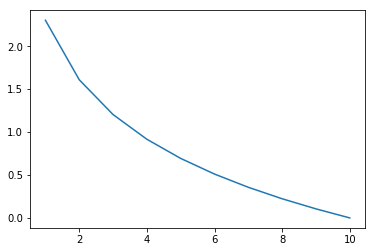

In [2]:
def idf(x):
    return np.log(10/x)

x = np.linspace(1,10,num=10)
plt.plot(x,idf(x))
plt.show()

In [3]:
class PreprocessIMDBData:
    def __init__(self):
        self.pattern = "[\w]+"
        self.stopword_set = set(stopwords.words('english'))
        
    def tokenizeSentence(self,text):
        tokenized_sentence = [w.lower() for w in nltk.regexp_tokenize(text,self.pattern)]
        cleanedSentence = list(set(tokenized_sentence).difference(self.stopword_set))
        return cleanedSentence

In [4]:
class VectorizeIMDBData:
    
    def __init__(self,tokenizerObj = PreprocessIMDBData()):
        self.tokenizerObj = tokenizerObj 
        self.tfidf = TfidfVectorizer(tokenizer=tokenizerObj.tokenizeSentence, ngram_range=(0, 1))
    
    def getTFIDFMatrix(self,docs):
        return self.tfidf.fit_transform(docs),self.tfidf.vocabulary_
    
    def getCleanedDocuments(self,docs, threshold = 0.6):
        scores,vocab = self.getTFIDFMatrix(docs)
        idf_inverse = 1/self.tfidf.idf_
        new_vocab_keys = (idf_inverse <= threshold)
        
        new_docs = []
        for doc_id,document in enumerate(docs):
            new_doc = []
            words = self.tokenizerObj.tokenizeSentence(document)
            for word in words:
                word_id  = vocab.get(word)
                if word_id is not None and new_vocab_keys[word_id]:
                    new_doc.append(word)
            
            cleanedDocument = ' '.join(new_doc)
            new_docs.append(cleanedDocument)
            
            del new_doc
        return new_docs
    
    def plot_words(self,threshold = [0.6]):
        max_figs_in_row = 5
        rows = int(np.ceil(len(threshold)/max_figs_in_row))
        cols  = np.minimum(len(threshold),max_figs_in_row)
        
        fig, axes = plt.subplots(rows, cols, figsize = (15, 9))
        
        vocab = self.tfidf.vocabulary_
        idf_inverse = 1/self.tfidf.idf_
        
        for i, ax in enumerate(fig.axes):
            frequencies = {}
            for key,value in vocab.items():
                if  value < len(idf_inverse) and idf_inverse[value] <= threshold[i]:
                    frequencies[key] = idf_inverse[value]
            
            if len(frequencies) <= 0:
                continue
            
            wc  = WordCloud(max_words=100)
            wc.generate_from_frequencies(frequencies)
            ax.imshow(wc, interpolation='bilinear')
            ax.set_axis_off()
        return

In [5]:
mytokenizer = PreprocessIMDBData()
myTfIdfGenerator = VectorizeIMDBData(mytokenizer)

                                            #################  Test tf-idf and tokenizer
# docs = ["The sun is shining allowance", "The sun weather is sweet", "the is shining and the weather is sweet"]
# cleaned_docs = myTfIdfGenerator.getCleanedDocuments(docs,threshold=0.8)
# print(cleaned_docs)

In [6]:
movies_actual = pd.read_csv('./the-movies-dataset/movies_metadata.csv',low_memory=False)
cols = ['id','title','genres','overview']
movies_df_clean = movies_actual[cols]
movies_df_clean = movies_df_clean[pd.notnull(movies_df_clean['overview'])]
movies_df_clean.info()
del movies_actual

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44512 entries, 0 to 45465
Data columns (total 4 columns):
id          44512 non-null object
title       44506 non-null object
genres      44512 non-null object
overview    44512 non-null object
dtypes: object(4)
memory usage: 1.7+ MB


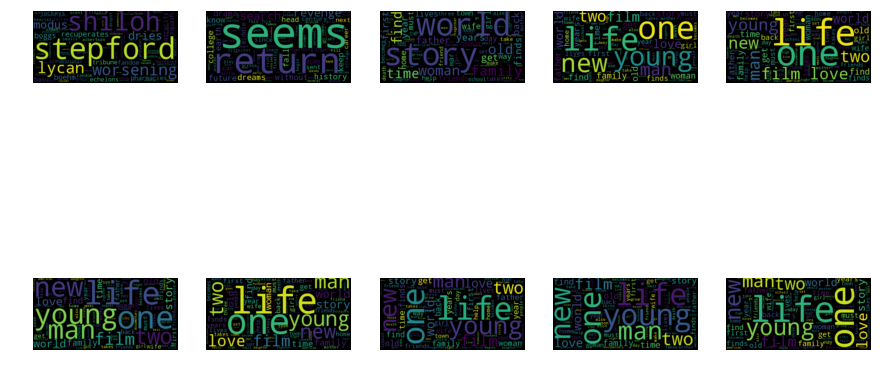

In [7]:
myTfIdfGenerator.getTFIDFMatrix(docs=list(movies_df_clean['overview']))
myTfIdfGenerator.plot_words(threshold=np.linspace(0.1,0.99,num=10))

In [8]:
overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = 0.6)
movies_df_clean['overview_cleaned'] = overview_cleaned

In [9]:
def plot_frequencies(movies_df_clean,cutoff = 0.00000001,columnName = 'overview',showGraph = False):
    mytokenizer = PreprocessIMDBData()
    genre_unkw = {}
    for index,row in movies_df_clean.iterrows():
        genresStr = row['genres']
        if pd.isnull(genresStr ):
            continue
        genreJson = json.loads(genresStr.replace("'",'"'))
        
        summary = set(mytokenizer.tokenizeSentence(row[columnName]))
        if len(summary) <= 0:
            continue
        
        for genreObject in genreJson:
            uniqueWords = set()
            if genreObject['name']  in genre_unkw:
                uniqueWords = genre_unkw[genreObject['name']]
            
            uniqueWords |= summary
            genre_unkw[genreObject['name']] = uniqueWords
            
    uniqueWordsSet = set()    
    uniqueWordsDict = {}
    for genre,uniqueWords in genre_unkw.items():
        uniqueGenreRep_Count = len(uniqueWords)
        uniqueWordsSet |= uniqueWords
        if uniqueGenreRep_Count <= cutoff * len(movies_df_clean):
            continue
        
        uniqueWordsDict[genre] = uniqueGenreRep_Count
        uniqueWordsDict['VocabSize'] = len(uniqueWordsSet)
        
    df = pd.DataFrame.from_dict(uniqueWordsDict, orient='index')
    if showGraph:
        df.plot(kind='bar')
    
    del uniqueWordsDict
    del genre_unkw
    return df

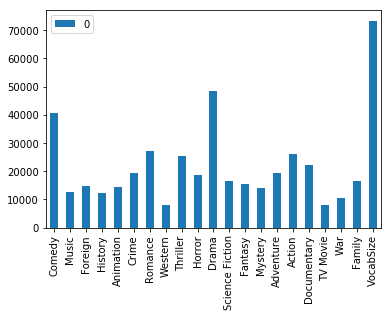

In [10]:
df = plot_frequencies(movies_df_clean,cutoff = 0.1,showGraph=True)

In [11]:
thresholds=np.linspace(0.1,0.99,num=10)

plots_list = list()
for threshold in thresholds:
    print("Analyzing for threshold ",threshold)
    overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = threshold)
    movies_df_clean['overview_cleaned'] = overview_cleaned
    df = plot_frequencies(movies_df_clean,cutoff=0.1,columnName='overview_cleaned')
    plots_list.append(df)
    print("Done with analysis")
print("------------->Done<-------------")

Analyzing for threshold  0.1
Done with analysis
Analyzing for threshold  0.198888888889
Done with analysis
Analyzing for threshold  0.297777777778
Done with analysis
Analyzing for threshold  0.396666666667
Done with analysis
Analyzing for threshold  0.495555555556
Done with analysis
Analyzing for threshold  0.594444444444
Done with analysis
Analyzing for threshold  0.693333333333
Done with analysis
Analyzing for threshold  0.792222222222
Done with analysis
Analyzing for threshold  0.891111111111
Done with analysis
Analyzing for threshold  0.99
Done with analysis
------------->Done<-------------


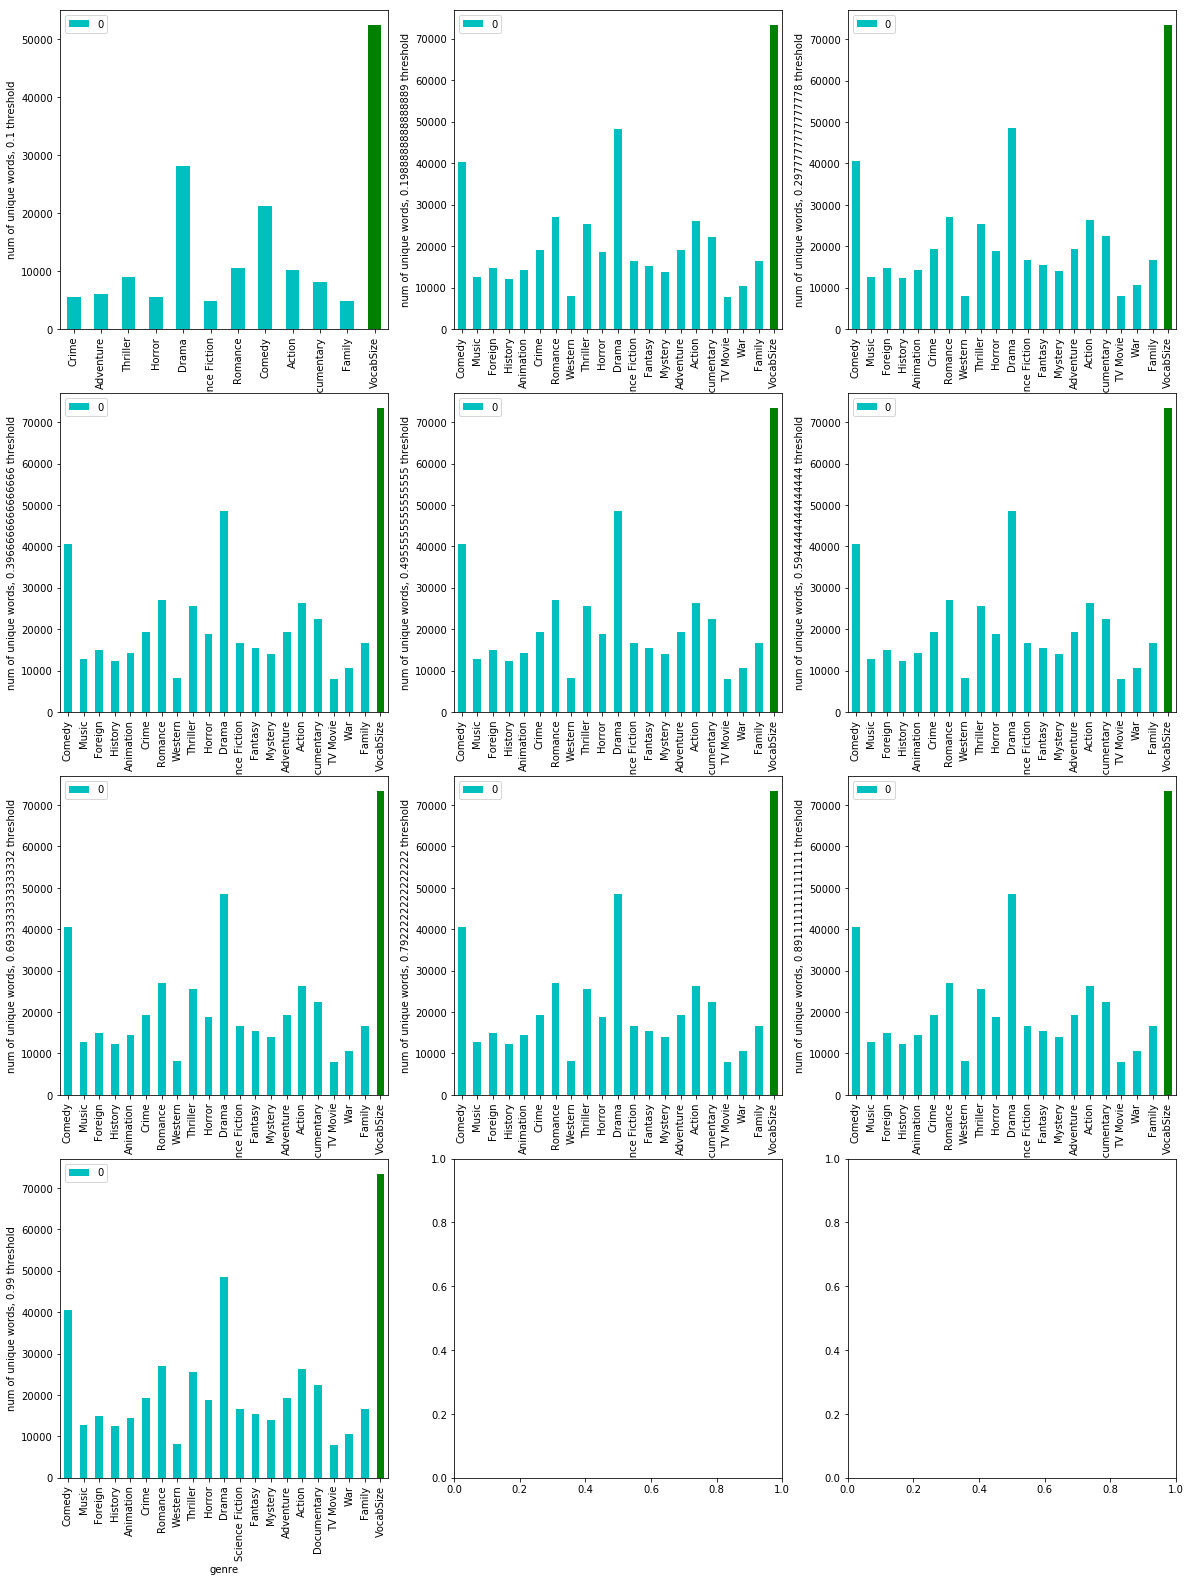

In [12]:
max_figs_in_row = 3
rows = int(np.ceil(len(plots_list)/max_figs_in_row))
cols  = np.minimum(len(plots_list),max_figs_in_row)

fig, axes = plt.subplots(rows, cols, figsize = (5*rows,9*cols))
for i, ax in enumerate(fig.axes):
    if i >= len(plots_list):
        continue
#     plots_list[i].plot(kind='bar',ax = ax)
    s = ['g' if index == 'VocabSize' else 'c' for index,value in plots_list[i][0].iteritems()]
    plots_list[i].plot(kind='bar',ax = ax,color = s)
    ax.set_xlabel("genre")
    ax.set_ylabel("num of unique words, {} threshold".format(thresholds[i]))

In [14]:
overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = 0.5)
movies_df_clean['overview_cleaned'] = overview_cleaned

# All genres have similar sentiments

In [43]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [44]:
class Utils:
    
    @staticmethod
    def getGenres(genresStr):
        if pd.isnull(genresStr ):
            return []
        
        genresInStr = []
        genreJson = json.loads(genresStr.replace("'",'"'))
        for genreObject in genreJson:
            genresInStr.append(genreObject['name'])
        
        return genresStr

In [45]:
class LabeledIMDBData:
    
    def __init__(self,df):
        self.df = df
        self.tokenizer = PreprocessIMDBData()
        self.to_array()
    
    def __iter__(self):
        for movie_data in self.movies:
            yield movie_data
    
    def to_array(self):
        self.movies = []
        for index,row in self.df.iterrows():
            self.movies.append(TaggedDocument(words = self.tokenizer.tokenizeSentence(row['overview_cleaned']),
                                              tags = Utils.getGenres( row['genres'])))
        return self.movies
    
    def generate_permutations(self):
        from random import shuffle
        shuffle(self.movies)
        return self.movies
    
    def datasetSize(self):
        return len(self.movies)

In [46]:
movies_data = LabeledIMDBData(movies_df_clean)
model = Doc2Vec(min_count=1, window=10, size=100, sample=1e-4, negative=5, workers=8)
model.build_vocab(movies_data.to_array())

In [ ]:
maxEpochRange = 10
for epoch in range(maxEpochRange):
    if epoch % 2 ==0 :
        print("Now at epoch number ",epoch," out of total number of epoch ",maxEpochRange)
        
    model.train(movies_data.generate_permutations(), total_examples=movies_data.datasetSize(), epochs=model.iter)
    model.alpha -= 0.002
    model.min_alpha = model.alpha

Now at epoch number  0  out of total number of epoch  10
Now at epoch number  2  out of total number of epoch  10
Now at epoch number  4  out of total number of epoch  10


In [31]:
model.save('./imdb.d2v')

In [32]:
movies_df_clean.head()

,id,title,genres,overview,overview_cleaned
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",eventually heart separate birthday learns circ...
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,proves alan creatures monkeys find terrifying ...
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,cooking time fishing seafood bait shop next we...
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",women breathe determined better robin breath f...
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,news pregnant planning recovered selling weddi...


In [35]:
model.most_similar('woman')

[('wife', 0.6681787967681885),
 ('leaves', 0.6477554440498352),
 ('lovers', 0.6421468257904053),
 ('possessive', 0.5729085206985474),
 ('seduction', 0.5725598931312561),
 ('fiancé', 0.5673124194145203),
 ('affair', 0.561942458152771),
 ('mother', 0.5584784746170044),
 ('child', 0.5443289279937744),
 ('embraces', 0.5402751564979553)]

In [36]:
model.most_similar('man')

[('fiancée', 0.6763216257095337),
 ('progressively', 0.6653105020523071),
 ('sour', 0.6653090715408325),
 ('reason', 0.6611945629119873),
 ('shock', 0.6604979038238525),
 ('jacobs', 0.6562535762786865),
 ('assume', 0.6518018841743469),
 ('crowded', 0.6439739465713501),
 ('angry', 0.6306031942367554),
 ('even', 0.6283088326454163)]

In [42]:
TaggedDocument?